In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from textblob import TextBlob
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Download and update NLTK stopwords
nltk.download('stopwords')

# Clean text data
def clean_text(text, additional_stopwords=set()):
    # Check if text is a string
    if not isinstance(text, str):
        return ""  # Remove NaN values
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    stopwords_combined = set(stopwords.words(['english', 'spanish', 'russian', 'portuguese'])) | additional_stopwords
    text = " ".join([word for word in text.split() if word not in stopwords_combined])
    return text

def main():
    
    df = pd.read_csv('sample_Coursera_reviews_0.05.csv')

    # Additional stopwords
    additional_stopwords = {'course','curso'}

    # Preprocess 'reviews' column
    df['reviews'] = df['reviews'].apply(lambda x: clean_text(x, additional_stopwords))

    # Save processed dataset
    df.to_csv('processed_Coursera_reviews_0.05.csv', index=False)

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anshullal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load processed dataset
df = pd.read_csv('processed_Coursera_reviews_0.05.csv')

# Calculate sentiment polarity
df['sentiment_polarity'] = df['reviews'].apply(lambda review: TextBlob(str(review)).sentiment.polarity)

# Calculate the average rating and sentiment polarity for each course
avg_course_metrics = df.groupby('course_id').agg({'rating':'mean', 'sentiment_polarity':'mean'}).reset_index()

# Create a subset of df with unique course names for TF-IDF vectorization
unique_courses = df[['course_id', 'name']].drop_duplicates()

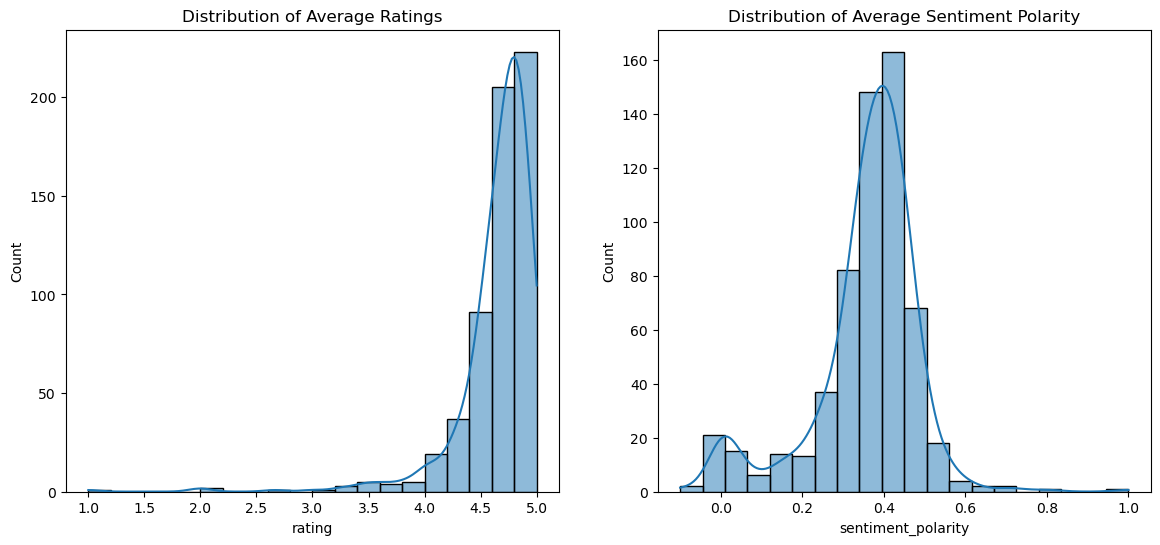

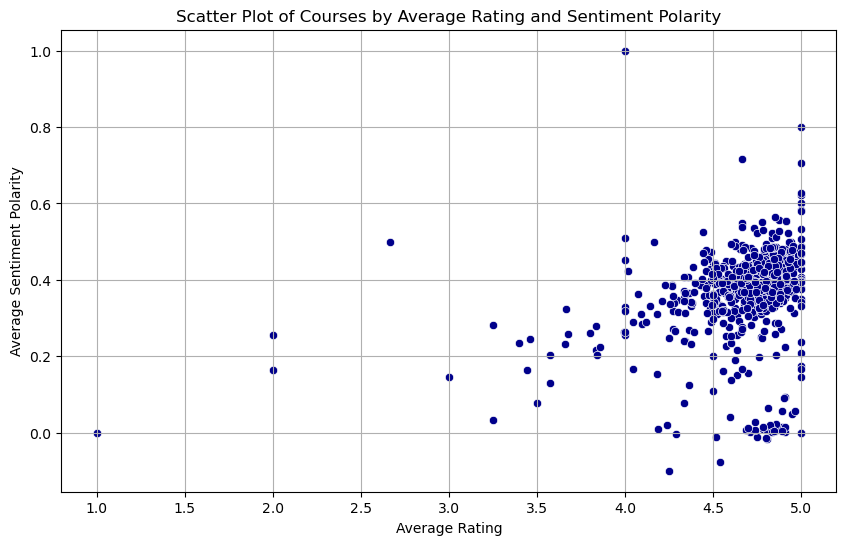

In [27]:
# Vectorize course names using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(unique_courses['name'])

# Ensure avg_course_metrics includes only those courses present in unique_courses
avg_course_metrics_filtered = avg_course_metrics[avg_course_metrics['course_id'].isin(unique_courses['course_id'])]

# Sort avg_course_metrics_filtered to ensure order matches with tfidf_matrix
avg_course_metrics_filtered = avg_course_metrics_filtered.set_index('course_id').loc[unique_courses['course_id']].reset_index()

# Standardise numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(avg_course_metrics_filtered[['rating', 'sentiment_polarity']])

# Combine TF-IDF features with standardised numeric features
combined_features = np.hstack((tfidf_matrix.toarray(), scaled_features))

# Plot distribution of average ratings and sentiment polarity
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(avg_course_metrics['rating'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Average Ratings')
sns.histplot(avg_course_metrics['sentiment_polarity'], bins=20, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Average Sentiment Polarity')
plt.show()

# Scatter Plot of Courses based on Average Rating and Sentiment Polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='sentiment_polarity', data=avg_course_metrics,color= "darkblue", legend="full")
plt.title('Scatter Plot of Courses by Average Rating and Sentiment Polarity')
plt.xlabel('Average Rating')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True)
plt.show()


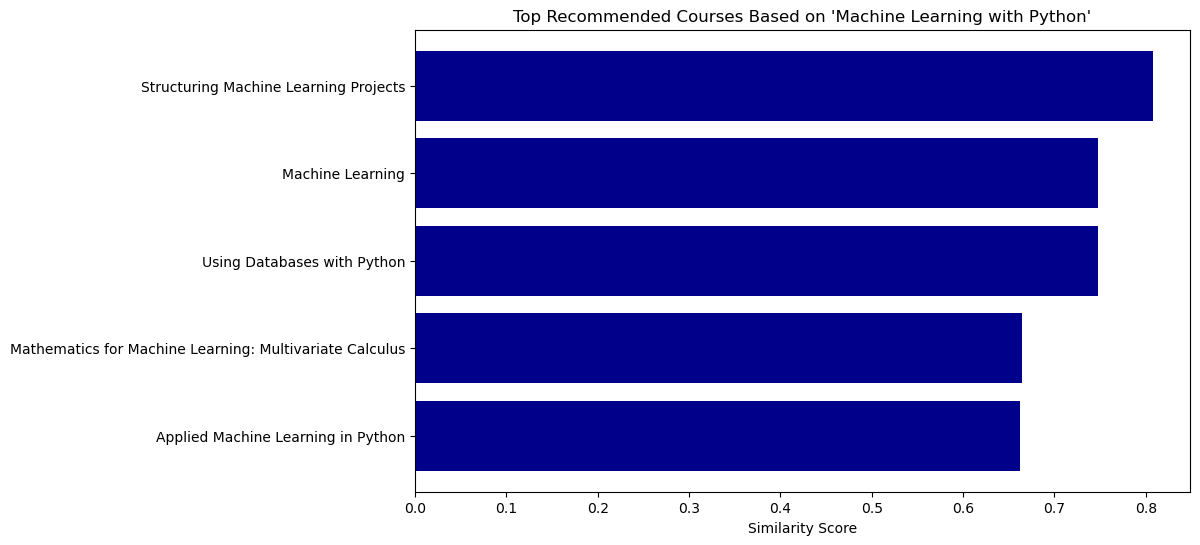

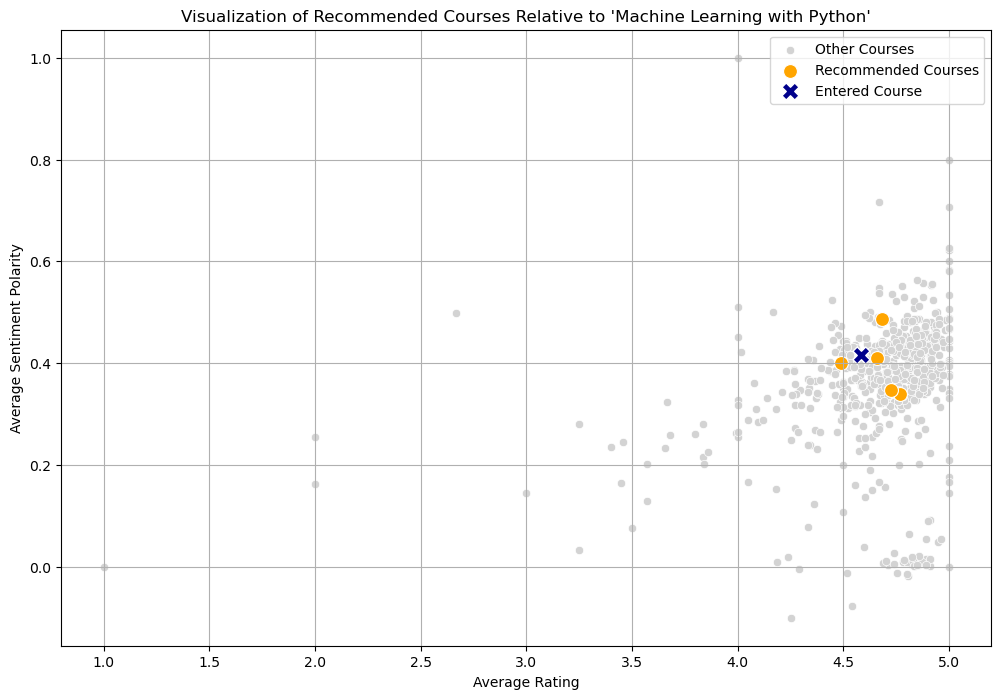

,course_id,name
0,machine-learning-projects,Structuring Machine Learning Projects
1,machine-learning,Machine Learning
2,python-databases,Using Databases with Python
3,multivariate-calculus-machine-learning,Mathematics for Machine Learning: Multivariate Calculus
4,python-machine-learning,Applied Machine Learning in Python


In [31]:
# Initialize the Nearest Neighbours model
knn = NearestNeighbors(n_neighbors=5, metric='cosine') # Enter the desired number of neighbours
knn.fit(combined_features)

# Create a mapping from course_id to the index in combined_features
course_id_to_index = {course_id: i for i, course_id in enumerate(unique_courses['course_id'])}

def recommend_courses_by_name(course_id, unique_courses, tfidf_matrix, course_id_to_name, tfidf_vectorizer, k=5): # Enter the desired number of neighbours
    if course_id not in course_id_to_name:
        print(f"Course ID '{course_id}' not found.")
        return None

    course_name = course_id_to_name[course_id]
    course_vector = tfidf_vectorizer.transform([course_name])
    similarity_scores = cosine_similarity(course_vector, tfidf_matrix).flatten()

    # Exclude the highest score since it's the course itself and get the top k indices
    sorted_indices = similarity_scores.argsort()[::-1]
    top_indices = [i for i in sorted_indices if unique_courses.iloc[i]['course_id'] != course_id][:k]
    
    recommended_course_ids = unique_courses.iloc[top_indices]['course_id'].tolist()
    recommended_courses_info = unique_courses[unique_courses['course_id'].isin(recommended_course_ids)]
    
    # Plotting top recommended courses with the similarity score
    plt.figure(figsize=(10, 6))
    plt.barh(recommended_courses_info['name'], similarity_scores[top_indices], color='darkblue')
    plt.xlabel('Similarity Score')
    plt.title(f"Top Recommended Courses Based on '{course_name}'")
    plt.gca().invert_yaxis()
    plt.show()

    # Visualization of recommended courses with respect to the entered course
    plotting_data = avg_course_metrics[avg_course_metrics['course_id'].isin(recommended_course_ids + [course_id])]
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='rating', y='sentiment_polarity', data=avg_course_metrics, color="lightgray", label="Other Courses")
    sns.scatterplot(x='rating', y='sentiment_polarity', data=plotting_data[plotting_data['course_id'] != course_id], color="orange", s=100, label="Recommended Courses")
    sns.scatterplot(x='rating', y='sentiment_polarity', data=plotting_data[plotting_data['course_id'] == course_id], color="darkblue", s=150, label="Entered Course", marker='X')
    plt.xlabel('Average Rating')
    plt.ylabel('Average Sentiment Polarity')
    plt.title(f"Visualization of Recommended Courses Relative to '{course_name}'")
    plt.legend()
    plt.grid(True)
    plt.show()

    return recommended_courses_info[['course_id', 'name']].reset_index(drop=True)

# Example usage by entering course_id to get recommendations
course_id_example = 'machine-learning-with-python'  # Enter course_id to get similar recommendations
recommendation_result = recommend_courses_by_name(course_id_example, unique_courses, tfidf_matrix, course_id_to_name, tfidf_vectorizer, k=5)
display(recommendation_result.style.set_caption("Top Recommended Courses"))